In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import os


In [14]:
#load dataset
df = pd.read_excel('../data/Data_Curah Hujan_2015-2024.xlsx')



--- Info Awal Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3637 entries, 0 to 3636
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TANGGAL  3637 non-null   object
 1   TN       3637 non-null   object
 2   TX       3637 non-null   object
 3   TAVG     3637 non-null   object
 4   RH_AVG   3637 non-null   object
 5   RR       3637 non-null   object
 6   SS       3637 non-null   object
 7   FF_X     3637 non-null   int64 
 8   DDD_X    3637 non-null   int64 
 9   FF_AVG   3637 non-null   int64 
 10  DDD_CAR  3637 non-null   object
dtypes: int64(3), object(8)
memory usage: 312.7+ KB

--- Statistik Deskriptif ---
           TANGGAL      TN    TX    TAVG  RH_AVG    RR    SS         FF_X  \
count         3637  3637.0  3637  3637.0  3637.0  3637  3637  3637.000000   
unique        3634    65.0    85    70.0    29.0   521   112          NaN   
top     10-07-2021    25.0     -    27.9    84.0     -     -          Na

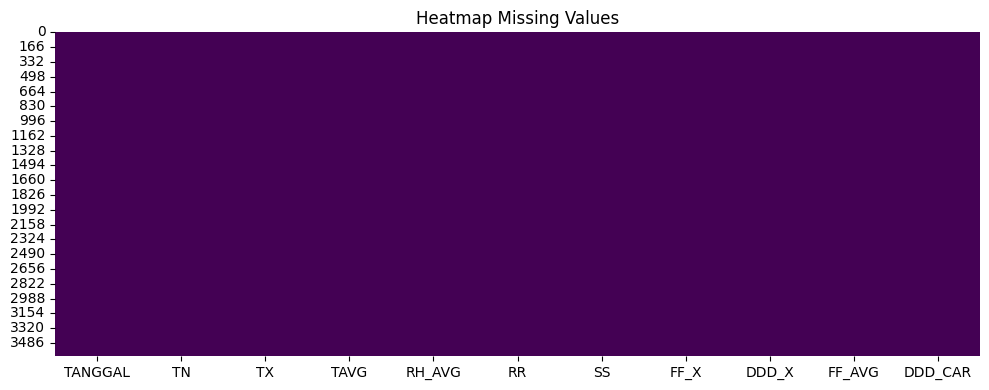

In [15]:
print("\n--- Info Awal Dataset ---")
df.info()

print("\n--- Statistik Deskriptif ---")
print(df.describe(include='all'))

print("\n--- Missing Value per Kolom ---")
print(df.isnull().sum())

# === Visualisasi Missing Value
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap Missing Values')
plt.tight_layout()
plt.show()



In [16]:
# missing value handling
df = df.replace(['8888', '9999', '-', 8888, 9999], np.nan).infer_objects()
numeric_columns = ['TN', 'TX', 'TAVG', 'RH_AVG', 'RR', 'SS']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

C:\Users\HP\AppData\Local\Temp\ipykernel_9084\4087331000.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(['8888', '9999', '-', 8888, 9999], np.nan).infer_objects()


In [17]:
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format='%d-%m-%Y')
df = df.sort_values(by='TANGGAL').reset_index(drop=True)


In [18]:
imputer = SimpleImputer(strategy='median')
columns_to_impute = df.select_dtypes(include=np.number).columns.tolist()
if 'TANGGAL' in columns_to_impute:
    columns_to_impute.remove('TANGGAL')
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [19]:
# === Feature Engineering ===
df['RR_lag1'] = df['RR'].shift(1)
df['TAVG_lag1'] = df['TAVG'].shift(1)
df['RH_AVG_lag1'] = df['RH_AVG'].shift(1)
df['SS_lag1'] = df['SS'].shift(1)
df['TX_lag1'] = df['TX'].shift(1)
df['TN_lag1'] = df['TN'].shift(1)
df['RR_rolling_mean_3d_lag1'] = df['RR'].rolling(window=3, min_periods=1).mean().shift(1)

df_preprocessed_full = df.copy()
df.dropna(inplace=True)

In [20]:
#kategorisasi target
def rr_categorization(rr):
    if rr == 0:
        return 'No Rain'
    elif rr <= 20:
        return 'Hujan Ringan'
    elif rr <= 50:
        return 'Hujan Sedang'
    elif rr <= 100:
        return 'Hujan Lebat'
    else:
        return 'Hujan Sangat Lebat'

df['RR_KAT'] = df['RR'].apply(rr_categorization)

In [21]:
#encoding 
le = LabelEncoder()
df['RR_KAT_ENC'] = le.fit_transform(df['RR_KAT'])


In [22]:
#feature engineering
feature_columns = [
    'TN', 'TX', 'TAVG', 'RH_AVG', 'SS',
    'RR_lag1', 'TAVG_lag1', 'RH_AVG_lag1',
    'SS_lag1', 'TX_lag1', 'TN_lag1',
    'RR_rolling_mean_3d_lag1'
]
X = df[feature_columns]
y = df['RR_KAT_ENC']

In [23]:
#standarisasi 
scaler= StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
# === SMOTE hanya di training ===
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


In [26]:
# === Training Model Default ===
nb_model = GaussianNB().fit(X_train_bal, y_train_bal)
knn_model = KNeighborsClassifier(n_neighbors=7).fit(X_train_bal, y_train_bal)
rf_model = RandomForestClassifier(random_state=42).fit(X_train_bal, y_train_bal)



--- Evaluasi Model Default ---

=== Naive Bayes ===
Akurasi: 0.25686813186813184
                    precision    recall  f1-score   support

       Hujan Lebat       0.16      0.23      0.19        26
      Hujan Ringan       0.85      0.12      0.21       521
Hujan Sangat Lebat       0.06      0.43      0.10         7
      Hujan Sedang       0.18      0.48      0.27        63
           No Rain       0.21      0.77      0.33       111

          accuracy                           0.26       728
         macro avg       0.29      0.40      0.22       728
      weighted avg       0.66      0.26      0.23       728


=== KNN ===
Akurasi: 0.39697802197802196
                    precision    recall  f1-score   support

       Hujan Lebat       0.11      0.38      0.18        26
      Hujan Ringan       0.81      0.38      0.52       521
Hujan Sangat Lebat       0.05      0.14      0.07         7
      Hujan Sedang       0.17      0.33      0.23        63
           No Rain       0.24   

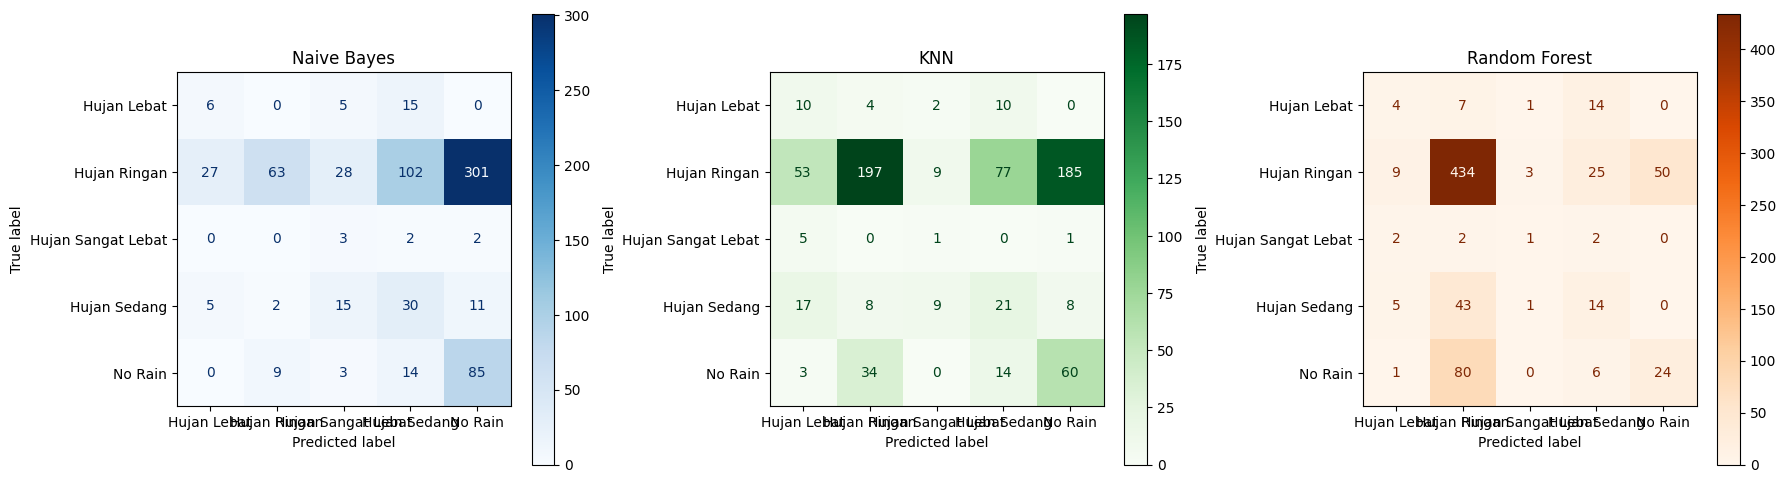

In [27]:
# === Evaluasi Model Default ===
print("\n--- Evaluasi Model Default ---")
for name, model in {
    'Naive Bayes': nb_model,
    'KNN': knn_model,
    'Random Forest': rf_model
}.items():
    y_pred = model.predict(X_test)
    print(f'\n=== {name} ===')
    print('Akurasi:', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# === Confusion Matrix ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ConfusionMatrixDisplay.from_estimator(nb_model, X_test, y_test, display_labels=le.classes_, cmap='Blues', ax=axes[0])
axes[0].set_title('Naive Bayes')
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test, display_labels=le.classes_, cmap='Greens', ax=axes[1])
axes[1].set_title('KNN')
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, display_labels=le.classes_, cmap='Oranges', ax=axes[2])
axes[2].set_title('Random Forest')
plt.tight_layout()
plt.show()

In [28]:
# === Cross Validation Default ===
print("\n--- Cross Validation (Default Models) ---")
default_models = {
    'GaussianNB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}
for name, model in default_models.items():
    scores = cross_val_score(model, X_train_bal, y_train_bal, cv=5, scoring='accuracy')
    print(f"{name} → CV Mean: {scores.mean():.4f}, Std: {scores.std():.4f}")



--- Cross Validation (Default Models) ---
GaussianNB → CV Mean: 0.4501, Std: 0.0115
KNN → CV Mean: 0.8613, Std: 0.0073
Random Forest → CV Mean: 0.9270, Std: 0.0196


In [30]:
def predict_from_input(last_data: dict, n_days=5):
    future_preds = []
    avg7 = df_preprocessed_full[numeric_columns].iloc[-7:].mean()
    last_date = last_data['TANGGAL']
    future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, n_days + 1)]

    for i, tgl in enumerate(future_dates):
        f = {
            'TN': avg7['TN'], 'TX': avg7['TX'], 'TAVG': avg7['TAVG'],
            'RH_AVG': avg7['RH_AVG'], 'RR': avg7['RR'], 'SS': avg7['SS']
        }

        if i == 0:
            f.update({
                'RR_lag1': last_data['RR'], 'TAVG_lag1': last_data['TAVG'], 'RH_AVG_lag1': last_data['RH_AVG'],
                'SS_lag1': last_data['SS'], 'TX_lag1': last_data['TX'], 'TN_lag1': last_data['TN'],
                'RR_rolling_mean_3d_lag1': df_preprocessed_full['RR'].iloc[-3:].mean()
            })
        else:
            f.update({
                'RR_lag1': avg7['RR'], 'TAVG_lag1': avg7['TAVG'], 'RH_AVG_lag1': avg7['RH_AVG'],
                'SS_lag1': avg7['SS'], 'TX_lag1': avg7['TX'], 'TN_lag1': avg7['TN'],
                'RR_rolling_mean_3d_lag1': avg7['RR']
            })

        row = pd.DataFrame([f])[feature_columns]
        scaled = scaler.transform(row)

        future_preds.append({
            'Tanggal': tgl.strftime('%Y-%m-%d'),
            'Naive Bayes': le.inverse_transform([nb_best.predict(scaled)[0]])[0],
            'KNN': le.inverse_transform([knn_best.predict(scaled)[0]])[0],
            'Random Forest': le.inverse_transform([rf_best.predict(scaled)[0]])[0]
        })

    return pd.DataFrame(future_preds)
